## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. I'll compute the camera calibration using chessboard images

./camera_cal/calibration1.jpg


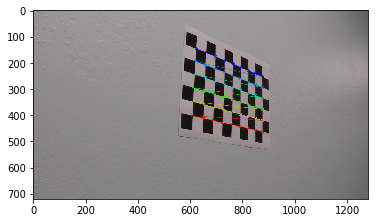

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
sampleImage = cv2.imread(images[0])
print(images[0])

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)

cv2.destroyAllWindows()

## Then we calibrate the camera

In [2]:
imageShape = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imageShape, None, None)

## Then we undistort the image

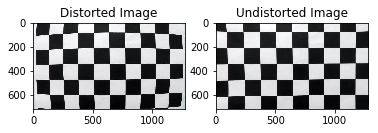

In [3]:
undistortedImage = cv2.undistort(sampleImage, mtx, dist, None, mtx)
plt.subplot(1,2,1)
plt.imshow(sampleImage)
plt.title('Distorted Image')
plt.subplot(1,2,2)
plt.imshow(undistortedImage)
plt.title('Undistorted Image')

## Now do it for all images (May be able to remove this block)

In [4]:
output_folder = './output_images/'

for fname in images:
    start = fname.rindex('/') + 1 # Start the name from after the '/'
    end = fname.rindex('.') # End at the dot so as to not have ".jpg" twice
    output_path = output_folder + fname[start:end] + "-undistorted"+ '.jpg'
    
    image = cv2.imread(fname)
    undistorted =  cv2.undistort(image, mtx, dist, None, mtx)
    cv2.imwrite(output_path, undistorted)
    

## 2. Now we can try undistorting a road image

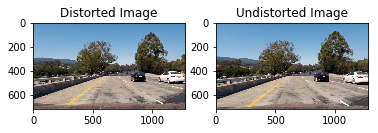

In [5]:
road_image = cv2.imread('./test_images/test1.jpg')
undistorted = cv2.undistort(road_image, mtx, dist, None, mtx)

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(road_image, cv2.COLOR_BGR2RGB))
plt.title('Distorted Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
plt.title('Undistorted Image')

The difference is pretty subtle, but is especially noticable around the white car on the right side of the image.

## 3. Now we can create a thresholded binary image.

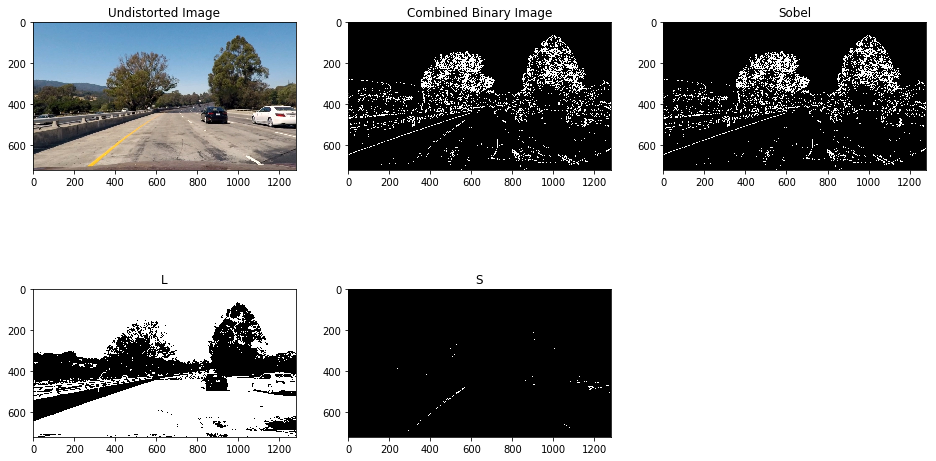

In [6]:
from project4 import binaryImage

sobel_thresh = [20, 100]
l_thresh = [90, 255]
s_thresh = [175, 250]

out_imgs = binaryImage(undistorted, sobel_thresh, l_thresh, s_thresh)
plt.figure(figsize=(16, 9))

plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
plt.title('Undistorted Image')

plt.subplot(2, 3, 2)
plt.imshow(out_imgs[0])
plt.title('Combined Binary Image')

plt.subplot(2, 3, 3)
plt.imshow(out_imgs[1])
plt.title('Sobel')

plt.subplot(2, 3, 4)
plt.imshow(out_imgs[2])
plt.title("L")

plt.subplot(2, 3, 5)
plt.imshow(out_imgs[3])
plt.title("S")


## 4. "Birds Eye View" Transform

To make things a bit easier, we will start the transform using the sample image that shows just a straight road:

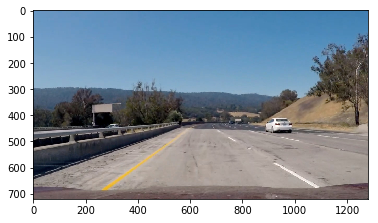

In [7]:
straight_image = cv2.imread("./test_images/trouble_img.jpg")
#straight_image = cv2.imread("./test_images/test5.jpg")
plt.imshow(cv2.cvtColor(straight_image, cv2.COLOR_BGR2RGB))

Then we pick the outline of the shape for transformation

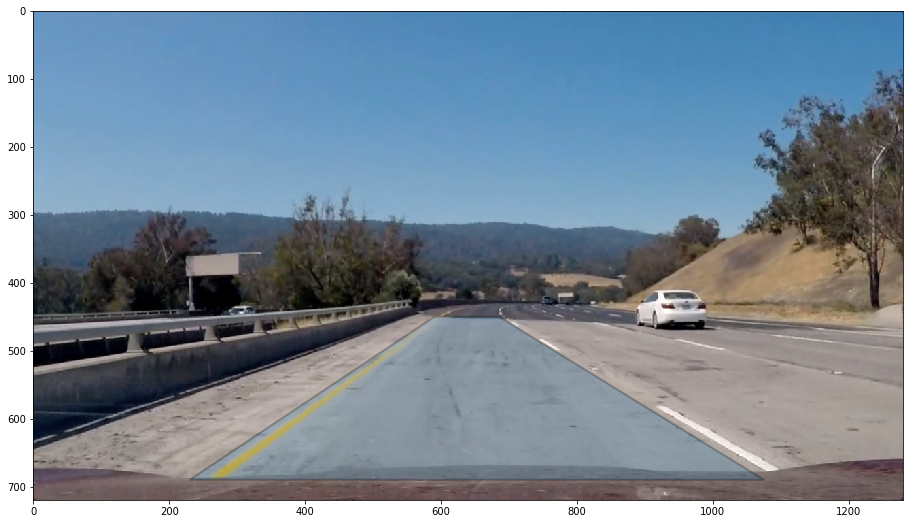

In [8]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

verts = [
    (230., 690.), # left, bottom
    (590., 450.), # left, top
    (685., 450.), # right, top
    (1075., 690.), # right, bottom
    (0., 0.), # ignored
    ]

codes = [Path.MOVETO,
         Path.LINETO,
         Path.LINETO,
         Path.LINETO,
         Path.CLOSEPOLY,
         ]

path = Path(verts, codes)

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
patch = patches.PathPatch(path, lw=2, alpha=0.25)
ax.add_patch(patch)
plt.imshow(cv2.cvtColor(straight_image, cv2.COLOR_BGR2RGB))

Which gives us the source points:

- (230,  690)
- (590,  450)
- (685,  450)
- (1075, 690)

We then chose the destination points to be:

- (300, 690)
- (300, 0)
- (970, 0)
- (1000, 690)

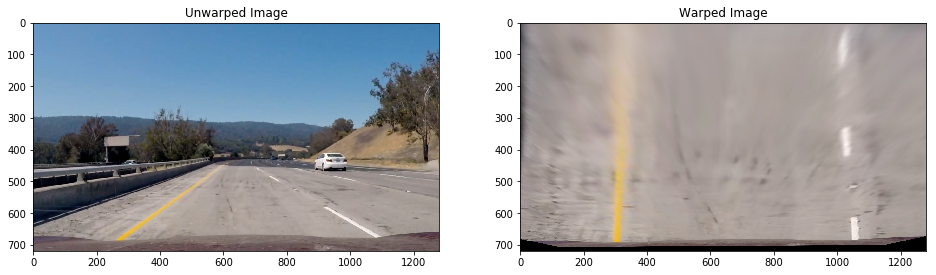

In [9]:
from project4 import warp

warped_img = warp(straight_image)

plt.figure(figsize=(16, 9))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(straight_image, cv2.COLOR_BGR2RGB))
plt.title('Unwarped Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
plt.title('Warped Image')

Then we can binarize the warped image:

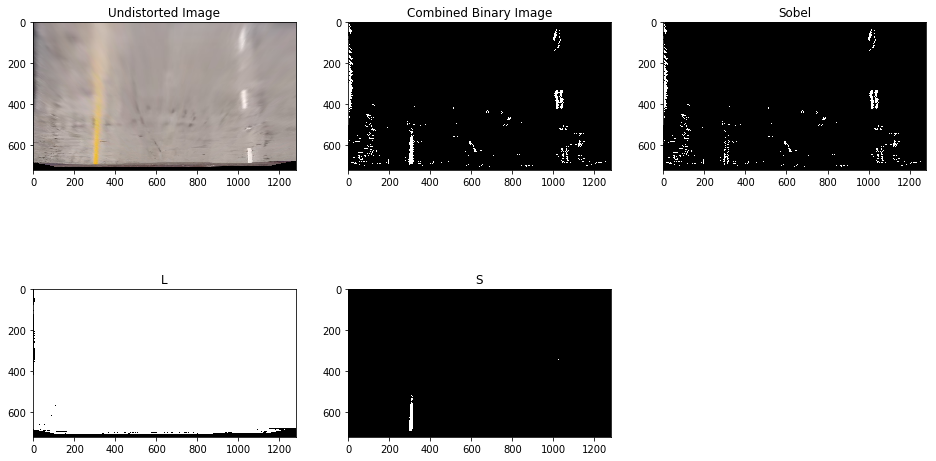

In [10]:
out_imgs = binaryImage(warped_img, sobel_thresh, l_thresh, s_thresh)
plt.figure(figsize=(16, 9))

plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
plt.title('Undistorted Image')

plt.subplot(2, 3, 2)
plt.imshow(out_imgs[0])
plt.title('Combined Binary Image')

plt.subplot(2, 3, 3)
plt.imshow(out_imgs[1])
plt.title('Sobel')

plt.subplot(2, 3, 4)
plt.imshow(out_imgs[2])
plt.title("L")

plt.subplot(2, 3, 5)
plt.imshow(out_imgs[3])
plt.title("S")

## 5. Determine the curvature of the lane and vehicle position with respect to center.

We begin be using a histogram on the transformed image to try to find the important regions.

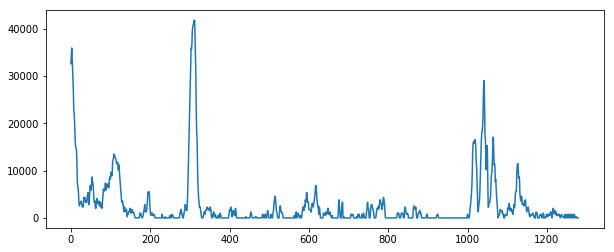

In [11]:
img = out_imgs[0]
plt.figure(figsize=(10,4))
histogram = np.sum(img[img.shape[0]//2:,:,0], axis=0)
plt.plot(histogram)

Then we need to to split the histogram in two and find each individual line

In [12]:
mid = np.int(histogram.shape[0] / 2)

leftx_base = np.argmax(histogram[0:mid])
rightx_base = np.argmax(histogram[mid:]) + mid # Add mid as an offset for splitting the image in half

print("Mid point")
print(mid)
print("First peak")
print(leftx_base)
print("Second peak")
print(rightx_base)

Mid point
640
First peak
310
Second peak
1041


Now setup the sliding window as shown in Lesson 16: Section 33, Finding the Lines

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

binary_warped = img

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 75
# Set minimum number of pixels found to recenter window
minpix = 35
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

Then Visualize

(720, 0)

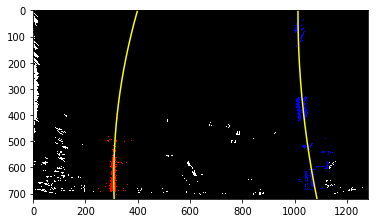

In [14]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.imshow(img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

Then we show how we can perform a smart search

In [15]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

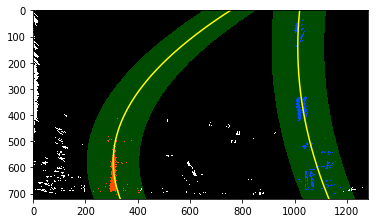

In [16]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(img)
# Color in left and right line pixels
img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

Now we do the super duper hard part

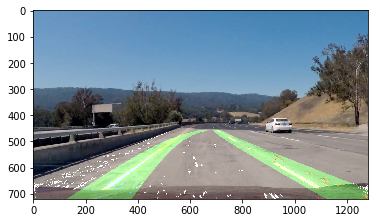

In [ ]:
from project4 import unwarp

unwarped_result = unwarp(result)

combined = cv2.add(unwarped_result, straight_image)

plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))

In [ ]:
from moviepy.editor import VideoFileClip
from project4 import Line

line = Line(mtx, dist)

out_file = "./processed_project_video.mp4"
in_file = "./project_video.mp4"

clip = VideoFileClip(in_file)
out_clip = clip.fl_image(line.analyze)
out_clip.write_videofile(out_file, audio=False)


[MoviePy] >>>> Building video ./processed_project_video.mp4
[MoviePy] Writing video ./processed_project_video.mp4


 99%|█████████▉| 1252/1261 [03:32<00:01,  6.27it/s]